In [92]:
%load_ext autoreload
%autoreload 2

# Check Schmidt Values

We check the trend of the schmidt values for different lattice sizes of the $\mathbb{Z}_2$ model.

In [176]:
from qs_mps.mps_class import MPS
from qs_mps.utils import tensor_shapes, von_neumann_entropy, load_list_of_lists
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

In [4]:
# let us retrieve the schmidt values from the tensors
lattice = MPS(L=7, d=64, chi=256, h=3.06, model="Z2_dual")
lattice.load_sites(path="/Users/fradm/Desktop/projects/1_Z2", precision=2)
lattice.L = lattice.L - 1
tensor_shapes(lattice.sites)
lattice.check_canonical(site=0)

(1, 64, 64)
(64, 64, 256)
(256, 64, 256)
(256, 64, 256)
(256, 64, 64)
(64, 64, 1)
the tensor at site 6 is in the correct RFC
the tensor at site 5 is in the correct RFC
the tensor at site 4 is in the correct RFC
the tensor at site 3 is in the correct RFC
the tensor at site 2 is in the correct RFC


In [5]:
lattice.canonical_form(svd_direction="right")
lattice.bonds[lattice.L // 2]

array([9.90912743e-01, 8.73556071e-02, 6.35354214e-02, 4.87155080e-02,
       3.99065065e-02, 3.42242968e-02, 3.33518815e-02, 7.12913212e-03,
       5.34182615e-03, 4.24056239e-03, 3.61954095e-03, 3.56394077e-03,
       3.43052704e-03, 2.97169732e-03, 2.54002328e-03, 2.46797922e-03,
       2.16043437e-03, 1.86960523e-03, 1.81665328e-03, 1.46374649e-03,
       1.42099410e-03, 1.16648279e-03, 6.79332416e-04, 4.71372972e-04,
       3.63160430e-04, 3.07207020e-04, 3.07189549e-04, 2.84981293e-04,
       2.64280204e-04, 2.22701343e-04, 2.12236869e-04, 1.86282797e-04,
       1.70626291e-04, 1.64687370e-04, 1.58978374e-04, 1.55273413e-04,
       1.51808914e-04, 1.33571979e-04, 1.24601398e-04, 1.19528584e-04,
       9.91714176e-05, 9.43743080e-05, 8.88857374e-05, 8.55423262e-05,
       7.17796156e-05, 7.13162100e-05, 6.53756136e-05, 6.19599228e-05,
       5.43115928e-05, 5.37830515e-05, 4.26352962e-05, 3.55514918e-05,
       3.07374869e-05, 2.81128997e-05, 2.75974581e-05, 2.57009649e-05,
      

In [28]:
out_vals = np.array([9.93929111e-01, 7.34952094e-02, 5.28744017e-02, 4.07422683e-02,
       3.36582755e-02, 3.21475833e-02, 5.16470314e-03, 3.89784880e-03,
       3.12915114e-03, 2.95743910e-03, 2.53641519e-03, 2.10594326e-03,
       2.00834282e-03, 1.51805982e-03, 1.44529170e-03, 1.11770101e-03,
       3.48809141e-04, 2.91587248e-04, 2.33010629e-04, 2.12161204e-04,
       1.64967300e-04, 1.59449677e-04, 1.54517205e-04, 1.18115150e-04,
       1.11919495e-04, 1.04435801e-04, 8.42850176e-05, 8.28083599e-05,
       5.68035185e-05, 5.36603695e-05, 4.82666319e-05, 3.30993049e-05,
       2.46699125e-05, 1.98004982e-05, 1.54215874e-05, 1.50221703e-05,
       1.38848166e-05, 1.38621399e-05, 1.22847764e-05, 1.16220979e-05,
       9.65779024e-06, 9.55866192e-06, 7.01352014e-06, 6.86536032e-06,
       6.74635346e-06, 6.54514226e-06, 5.47386922e-06, 5.41445566e-06,
       4.74541327e-06, 4.74102691e-06, 4.13916490e-06, 3.74749494e-06,
       3.50450070e-06, 3.18486410e-06, 3.15892518e-06, 2.75885130e-06,
       2.53412850e-06, 2.38589731e-06, 2.33508667e-06, 2.23597795e-06,
       1.82648162e-06, 1.80990163e-06, 1.67029700e-06, 1.47096288e-06,
       1.43347192e-06, 1.42921337e-06, 1.13868899e-06, 1.12762200e-06,
       9.91021315e-07, 9.00999836e-07, 8.63270191e-07, 8.51366046e-07,
       6.65939313e-07, 6.56371801e-07, 6.16878749e-07, 6.09913423e-07,
       5.89048685e-07, 5.25698712e-07, 4.98873669e-07, 4.82780164e-07,
       4.19546988e-07, 4.10371513e-07, 4.00094610e-07, 3.78629203e-07,
       3.65914202e-07, 3.59477445e-07, 3.20106836e-07, 2.88275127e-07,
       2.76533134e-07, 2.55410377e-07, 2.52153797e-07, 2.38390053e-07,
       2.35500543e-07, 2.23963589e-07, 2.08467203e-07, 2.05664333e-07,
       2.01187470e-07, 1.95607045e-07, 1.81971057e-07, 1.79045056e-07,
       1.71294166e-07, 1.70070350e-07, 1.55306606e-07, 1.45613984e-07,
       1.38145938e-07, 1.29408589e-07, 1.25963710e-07, 1.25256152e-07,
       1.13187648e-07, 9.87313489e-08, 9.31058496e-08, 9.13666521e-08,
       8.56291067e-08, 7.84980539e-08, 7.48771950e-08, 7.38627282e-08,
       6.16095347e-08, 5.75512421e-08, 5.62427455e-08, 4.94123769e-08,
       4.28056863e-08, 3.76087933e-08, 3.24351254e-08, 3.06814162e-08,
       3.04202716e-08, 2.67351532e-08, 2.13443098e-08, 1.88046100e-08])

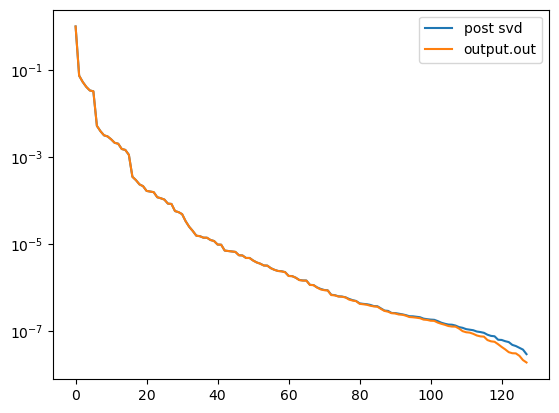

In [40]:
plt.plot(lattice.bonds[lattice.L // 2], label="post svd")
plt.plot(out_vals, label="output.out")
plt.yscale('log')
plt.legend()
plt.show()

### Now we can iterate the above process

In [196]:
# let us retrieve the schmidt values from the tensors
schmidt_vals_chi = []
entropy_chi = []
bond_dim_chi = []
hs = np.logspace(1,-3,50)
chis = [16,32,64,128]
threshold = 1e-15
params = [[h,chi] for chi in chis for h in hs]
params_extent = np.concatenate([np.min(params, axis=0), np.max(params, axis=0)])
params_extent = tuple(params_extent[[0, 2, 1, 3]])
prob = []
for chi in chis:
    schmidt_vals_h = []
    bond_dim_h = []
    entropy_h = []
    for h in hs:
        lattice = MPS(L=5, d=16, chi=chi, h=h, model="Z2_dual")
        lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=3)
        lattice.L = lattice.L - 1
        lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
        sm = lattice.bonds[lattice.L // 2].copy()
        prob = np.sum(sm**2)
        print("pre", len(sm), sm[-1], prob)
        sm = sm[sm > threshold]
        prob = np.sum(sm**2)
        print("post", len(sm), sm[-1], prob)
        entr = von_neumann_entropy(sm)
        entropy_h.append(entr)
        schmidt_vals_h.append(sm[-1])
        bond_dim_h.append(len(sm))
    schmidt_vals_chi.append(schmidt_vals_h)
    bond_dim_chi.append(bond_dim_h)
    entropy_chi.append(entropy_h)

pre 16 9.999993965598038e-16 1.0000062500387892
post 15 1.2944562352121508e-14 1.0000062500387892
pre 16 1.0000870128322917e-15 1.000013256117549
post 16 1.0000870128322917e-15 1.000013256117549
pre 16 1.0185131562890637e-15 1.0000281159891709
post 16 1.0185131562890637e-15 1.0000281159891709
pre 16 1.9763323638056613e-15 1.0000596344985864
post 16 1.9763323638056613e-15 1.0000596344985864
pre 16 1.6201903325522823e-14 1.000126490239167
post 16 1.6201903325522823e-14 1.000126490239167
pre 16 1.539374939314417e-13 1.0002683173617934
post 16 1.539374939314417e-13 1.0002683173617934
pre 16 1.464731530648605e-12 1.0005692579391423
post 16 1.464731530648605e-12 1.0005692579391423
pre 16 1.330403964754245e-11 1.001208133369189
post 16 1.330403964754245e-11 1.001208133369189
pre 16 1.3133524188366794e-10 1.0025658390558818
post 16 1.3133524188366794e-10 1.0025658390558818
pre 16 1.2630381463748444e-09 1.0054575762509645
post 16 1.2630381463748444e-09 1.0054575762509645
pre 16 1.23669070421968

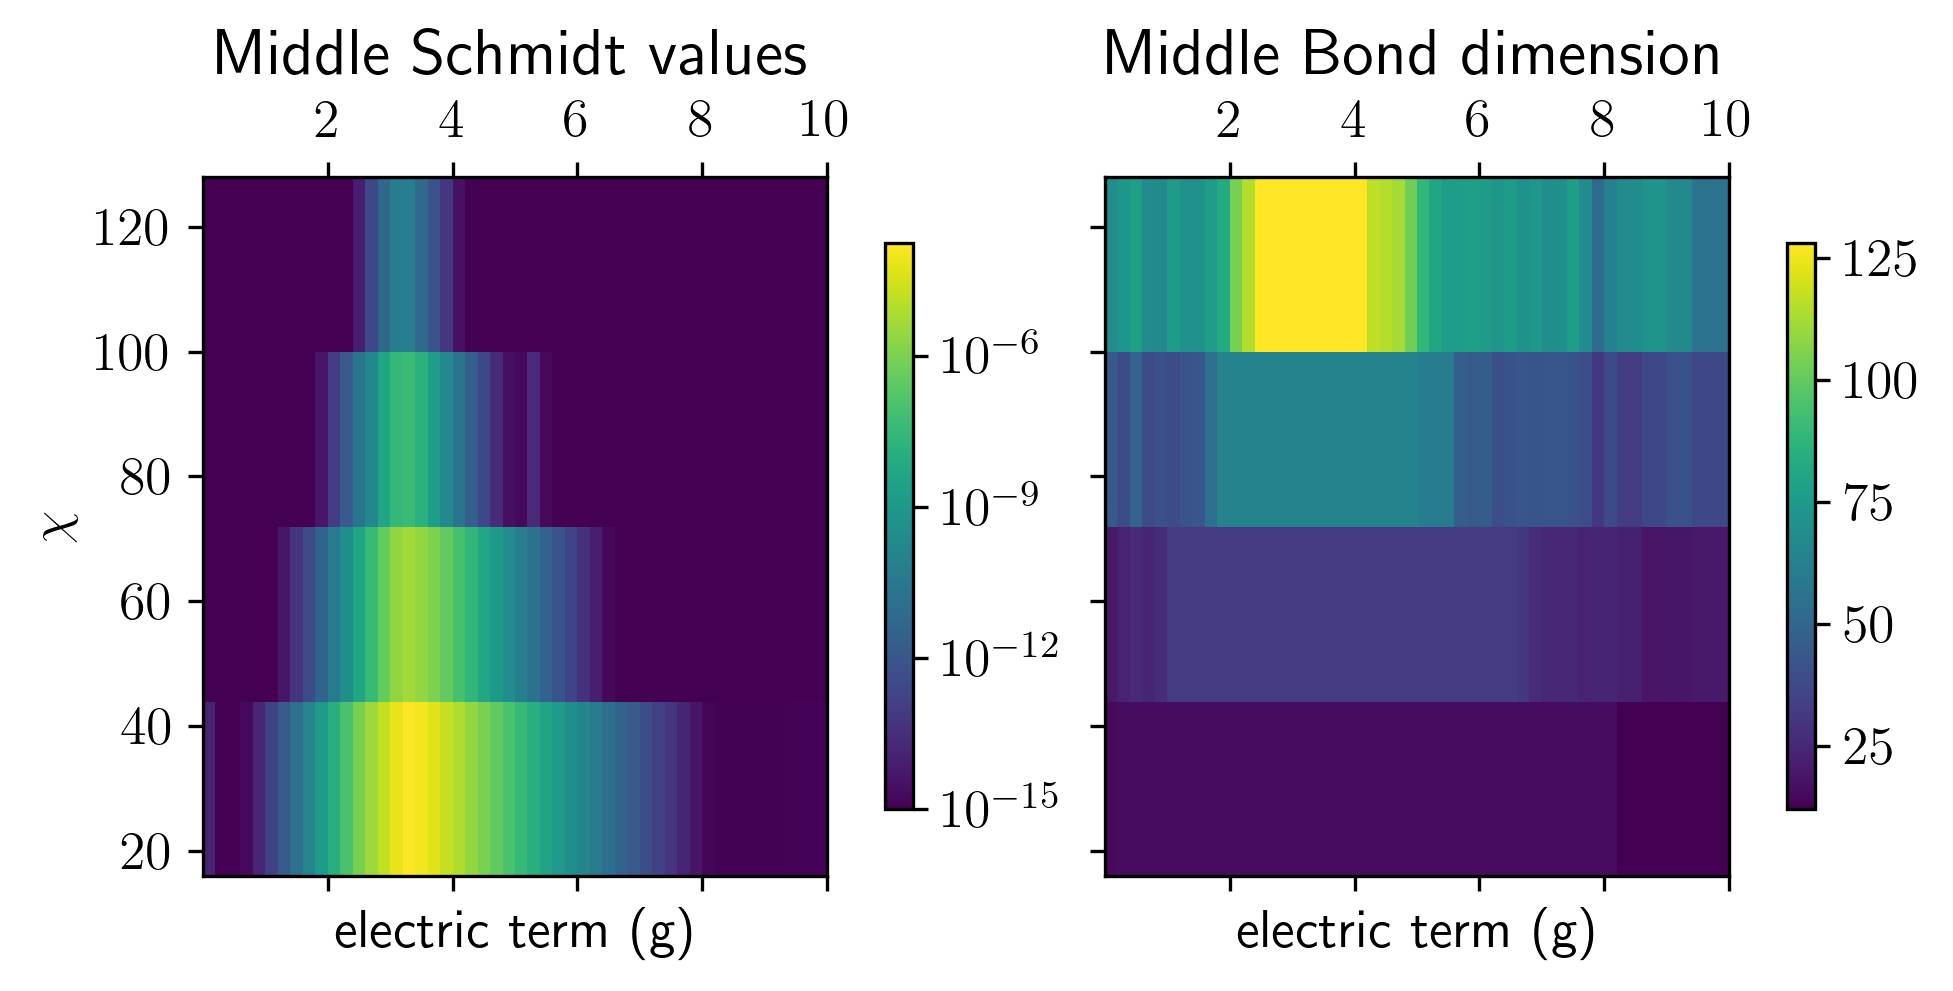

In [220]:
from matplotlib import colors
fig, axs = plt.subplots(1,2, sharey=True)
matshow0 = axs[0].matshow(schmidt_vals_chi, origin='lower', extent=params_extent, aspect=0.1, norm=colors.LogNorm(vmin=np.min(schmidt_vals_chi), vmax=np.max(schmidt_vals_chi)))
axs[0].set_title("Middle Schmidt values")
axs[0].set_ylabel("$\chi$")
axs[0].set_xlabel("electric term (g)")
matshow1 = axs[1].matshow(bond_dim_chi, origin='lower', extent=params_extent, aspect=0.1)
axs[1].set_title("Middle Bond dimension")
axs[1].set_xlabel("electric term (g)")
fig.colorbar(matshow0, ax=axs[0], shrink=0.4)
fig.colorbar(matshow1, ax=axs[1], shrink=0.4)

## Entropy

16
0) pre size = 16, 1.964263507786241e-18, post size = 15, 1.2905545757547584e-14
    pre entr = -3.248238838637907e-11,	 post entr = -3.248238838637907e-11
0) pre size = 16, 1.964263507786241e-18, post size = 15, 1.2905545757547584e-14
1) pre size = 16, 1.7015624732601128e-17, post size = 15, 5.804844596450076e-14
    pre entr = -1.3877997747841083e-10,	 post entr = -1.3877997747841083e-10
1) pre size = 16, 1.7015624732601128e-17, post size = 15, 5.804844596450076e-14
2) pre size = 16, 1.9620740651283663e-16, post size = 15, 2.6101137970200414e-13
    pre entr = -5.912760067082818e-10,	 post entr = -5.912760067082818e-10
2) pre size = 16, 1.9620740651283663e-16, post size = 15, 2.6101137970200414e-13
3) pre size = 16, 1.7165999069099612e-15, post size = 16, 1.7165999069099612e-15
    pre entr = -2.5113026594547263e-09,	 post entr = -2.5113026594547263e-09
3) pre size = 16, 1.7165999069099612e-15, post size = 16, 1.7165999069099612e-15
4) pre size = 16, 1.5676320968488934e-14, post si

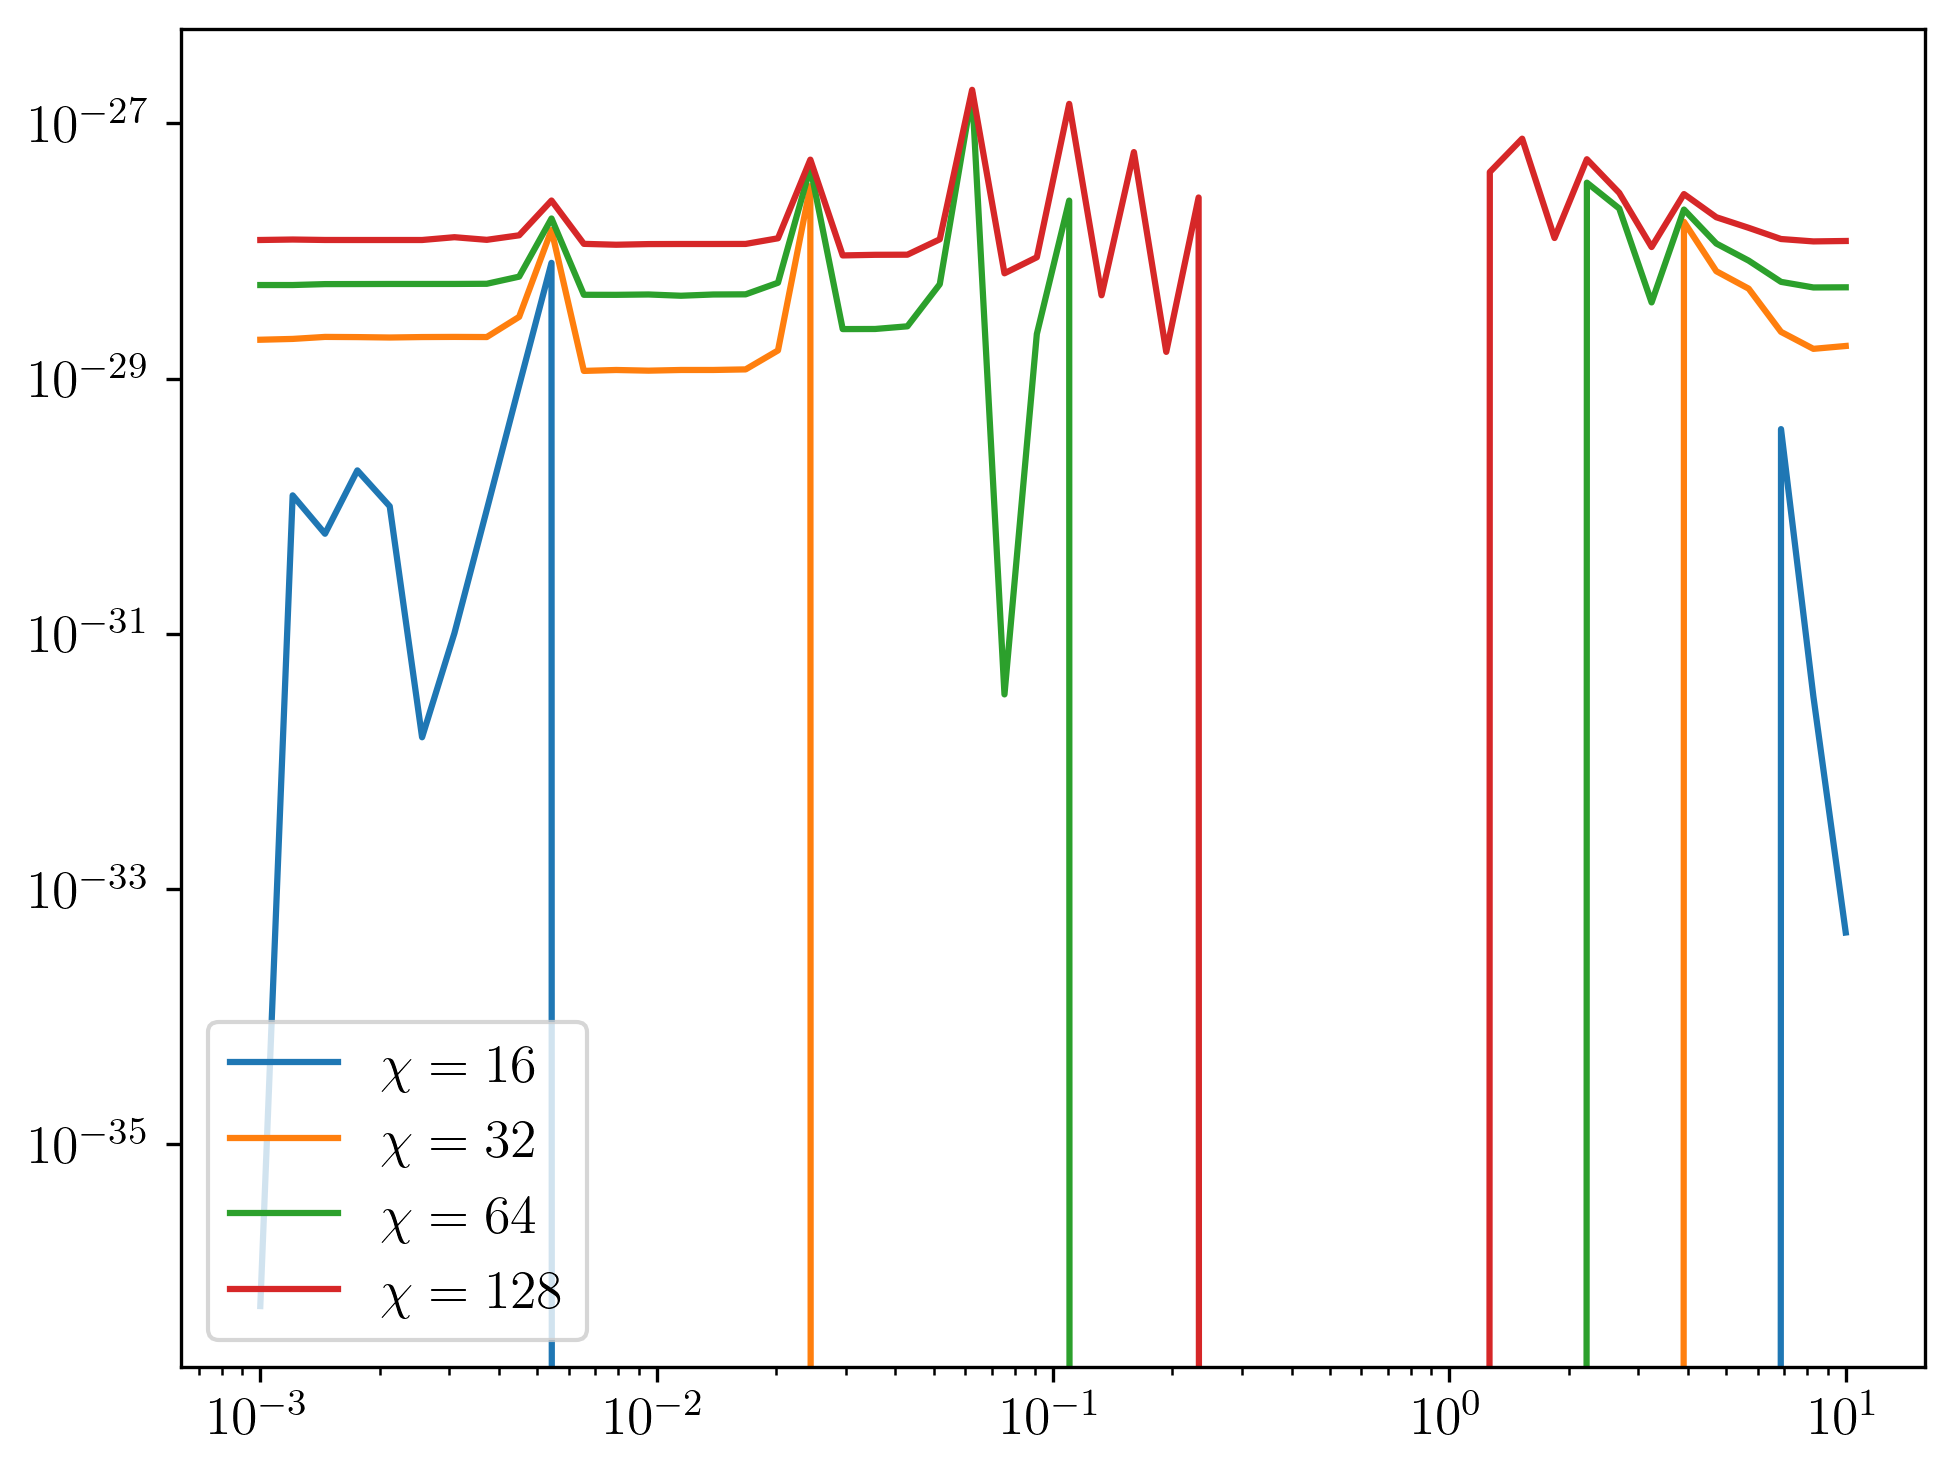

In [241]:
parent_path="/Users/fradm98/Google Drive/My Drive/projects/1_Z2"
l = 4
L = 5
h_i = 1.0
h_f = -3.0
sector = "vacuum_sector"
npoints = 50
chis = [16,32,64,128]
threshold = 1e-15
for chi, entropy in zip(chis, entropy_chi):
    print(chi)
    sm_h = np.load(f"{parent_path}/results/entropy_data/2_schmidt_vals_Z2_dual_direct_lattice_{l}x{L-1}_{sector}_None-None_h_{h_i}-{h_f}_delta_{npoints}_chi_{chi}.npy", allow_pickle=True)
    sm_h = sm_h.reshape((npoints, chi))
    entr_h = []
    for i, sm in enumerate(sm_h):
        pre_sm = sm
        post_sm = sm[sm > threshold].copy()
        print(f"{i}) pre size = {len(pre_sm)}, {pre_sm[-1]}, post size = {len(post_sm)}, {post_sm[-1]}")
        # pre_entr = - np.sum( pre_sm**2 * np.log(pre_sm**2))
        pre_entr = sum([ x**2 * np.log(x**2) for x in pre_sm])
        post_entr = sum([ x**2 * np.log(x**2) for x in post_sm])
        # entr_h.append(-post_entr)
        # post_entr = - np.sum( post_sm**2 * np.log(post_sm**2))
        print(f"    pre entr = {pre_entr},\t post entr = {post_entr}")
        print(f"{i}) pre size = {len(pre_sm)}, {pre_sm[-1]}, post size = {len(post_sm)}, {post_sm[-1]}")

        sm = sm[sm < threshold]
        entr_res = von_neumann_entropy(sm)
        entr_h.append(entr_res)
    #     prob = np.sum(sm**2)
    #     print("pre", len(sm), sm[-1], prob)
    #     sm = sm[sm > threshold]
    #     prob = np.sum(sm**2)
    #     print("post", len(sm), sm[-1], prob)
    #     entr = von_neumann_entropy(sm)
    #     entr_h.append(entr)
    plt.plot(hs, entr_h, label=f"$\chi={chi}$")


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# let us retrieve the schmidt values from the tensors
hs = np.logspace(1,-3,50)
chi = 64
threshold = 1e-15

schmidt_vals_h = []
for h in hs:
    lattice = MPS(L=4, d=8, chi=chi, h=h, model="Z2_dual")
    lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=3)
    lattice.L = lattice.L - 1
    lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
    sm = lattice.bonds[lattice.L // 2].copy()
    schmidt_vals_h.append(sm)
    print(len(sm))

Text(0.5, 1.0, 'Schmidt values decay for $3$x$3$ direct lattice - $\\chi=8$')

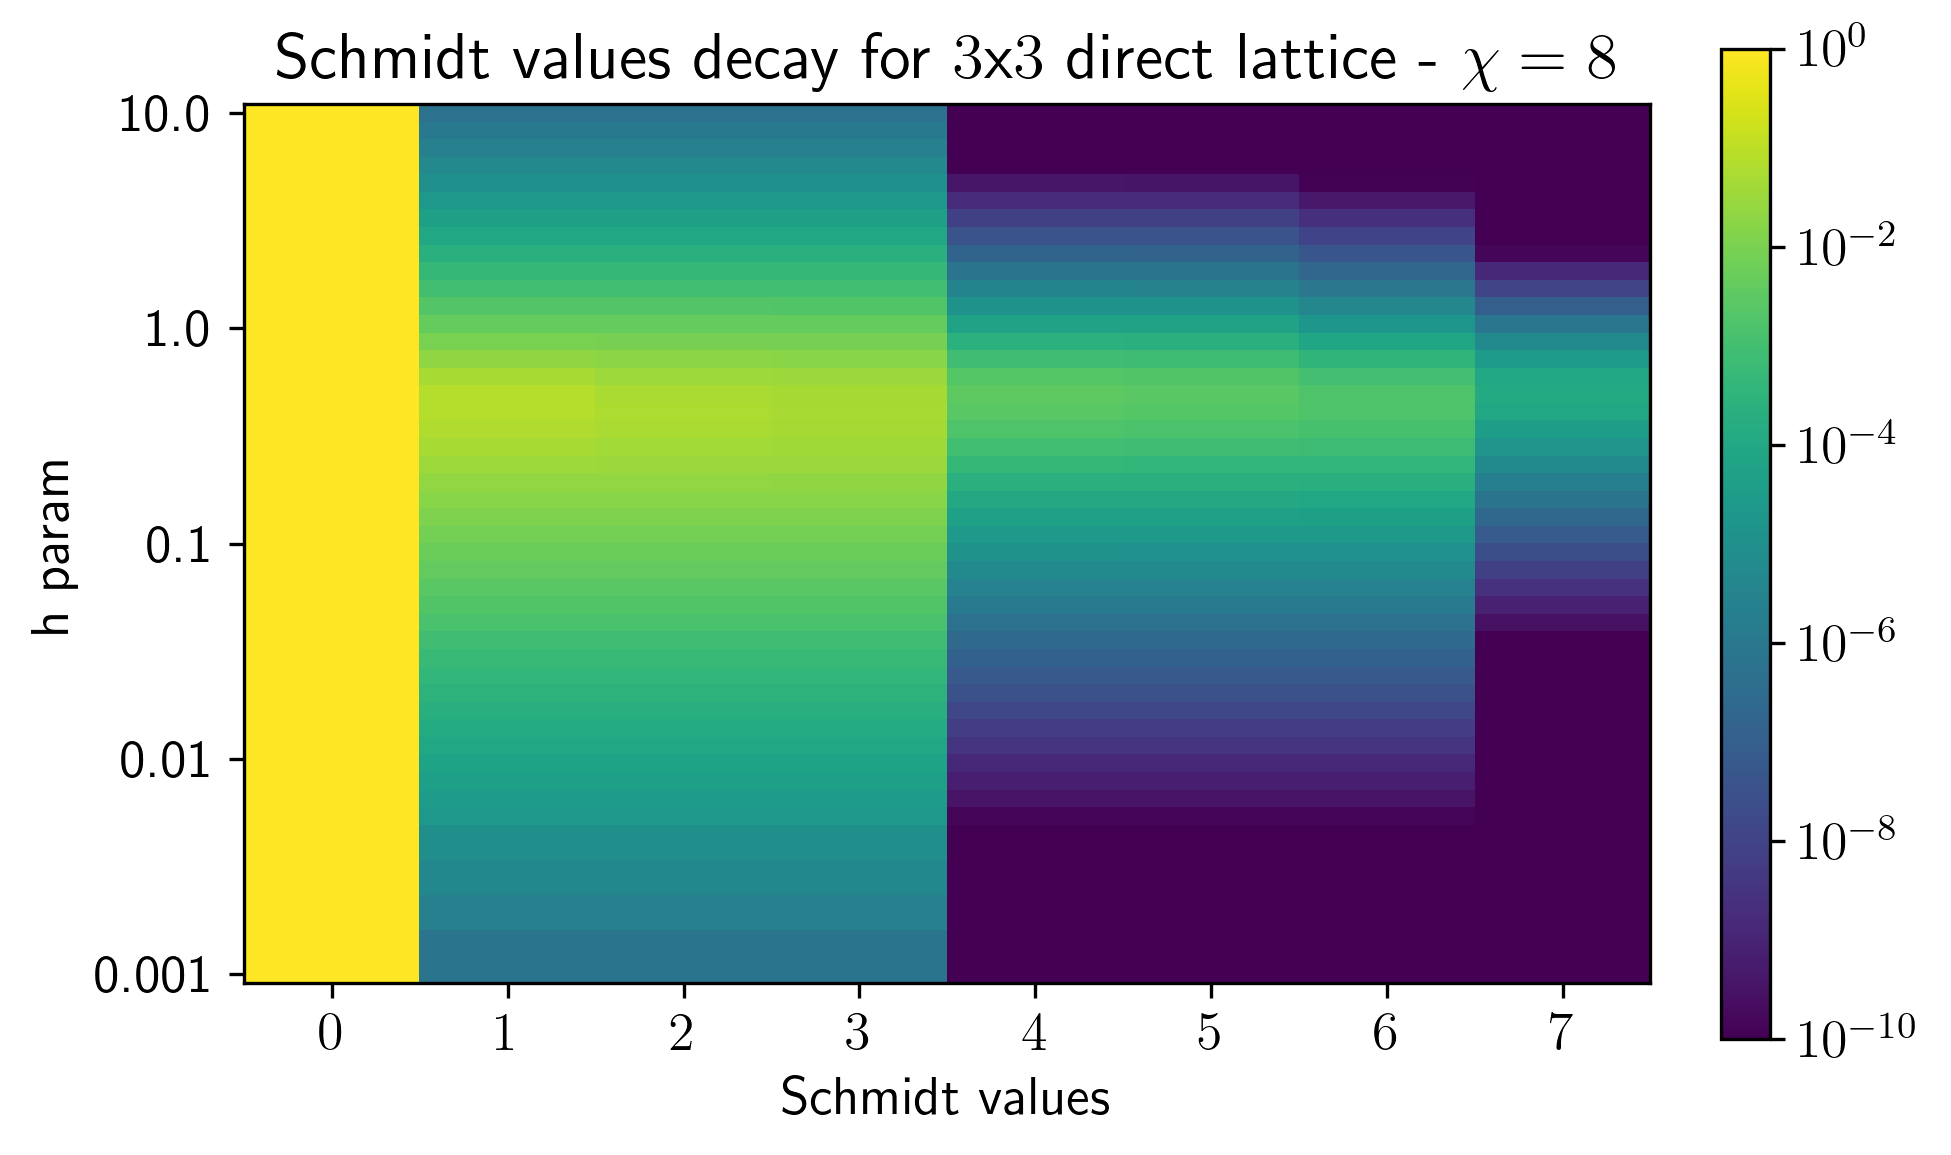

In [146]:
plt.imshow(schmidt_vals_h, cmap="viridis", norm=mpl.colors.LogNorm(vmin=1e-10, vmax=1), aspect=0.1)
plt.colorbar(shrink=0.7)
hs_y = np.logspace(1,-3,5)
y = np.linspace(0,49,5)
plt.yticks(y, hs_y)
# plt.yscale('log')
plt.ylabel("h param")
plt.xlabel("Schmidt values")
plt.title("Schmidt values decay for $3$x$3$ direct lattice - $\chi=8$")


In [236]:
sm_crit = []
chis = [128]
for chi in chis:
    for h in hs:
        # print(h)
        lattice = MPS(L=5, d=16, chi=chi, h=h, model="Z2_dual")
        lattice.load_sites(path="/Users/fradm98/Desktop/projects/1_Z2", precision=3)
        lattice.L = lattice.L - 1
        lattice.canonical_form(svd_direction="right", trunc_chi=True, trunc_tol=False)
        sm = lattice.bonds[lattice.L // 2].copy()
        if round(h, 3) == 0.596:
            sm_crit.append(sm)


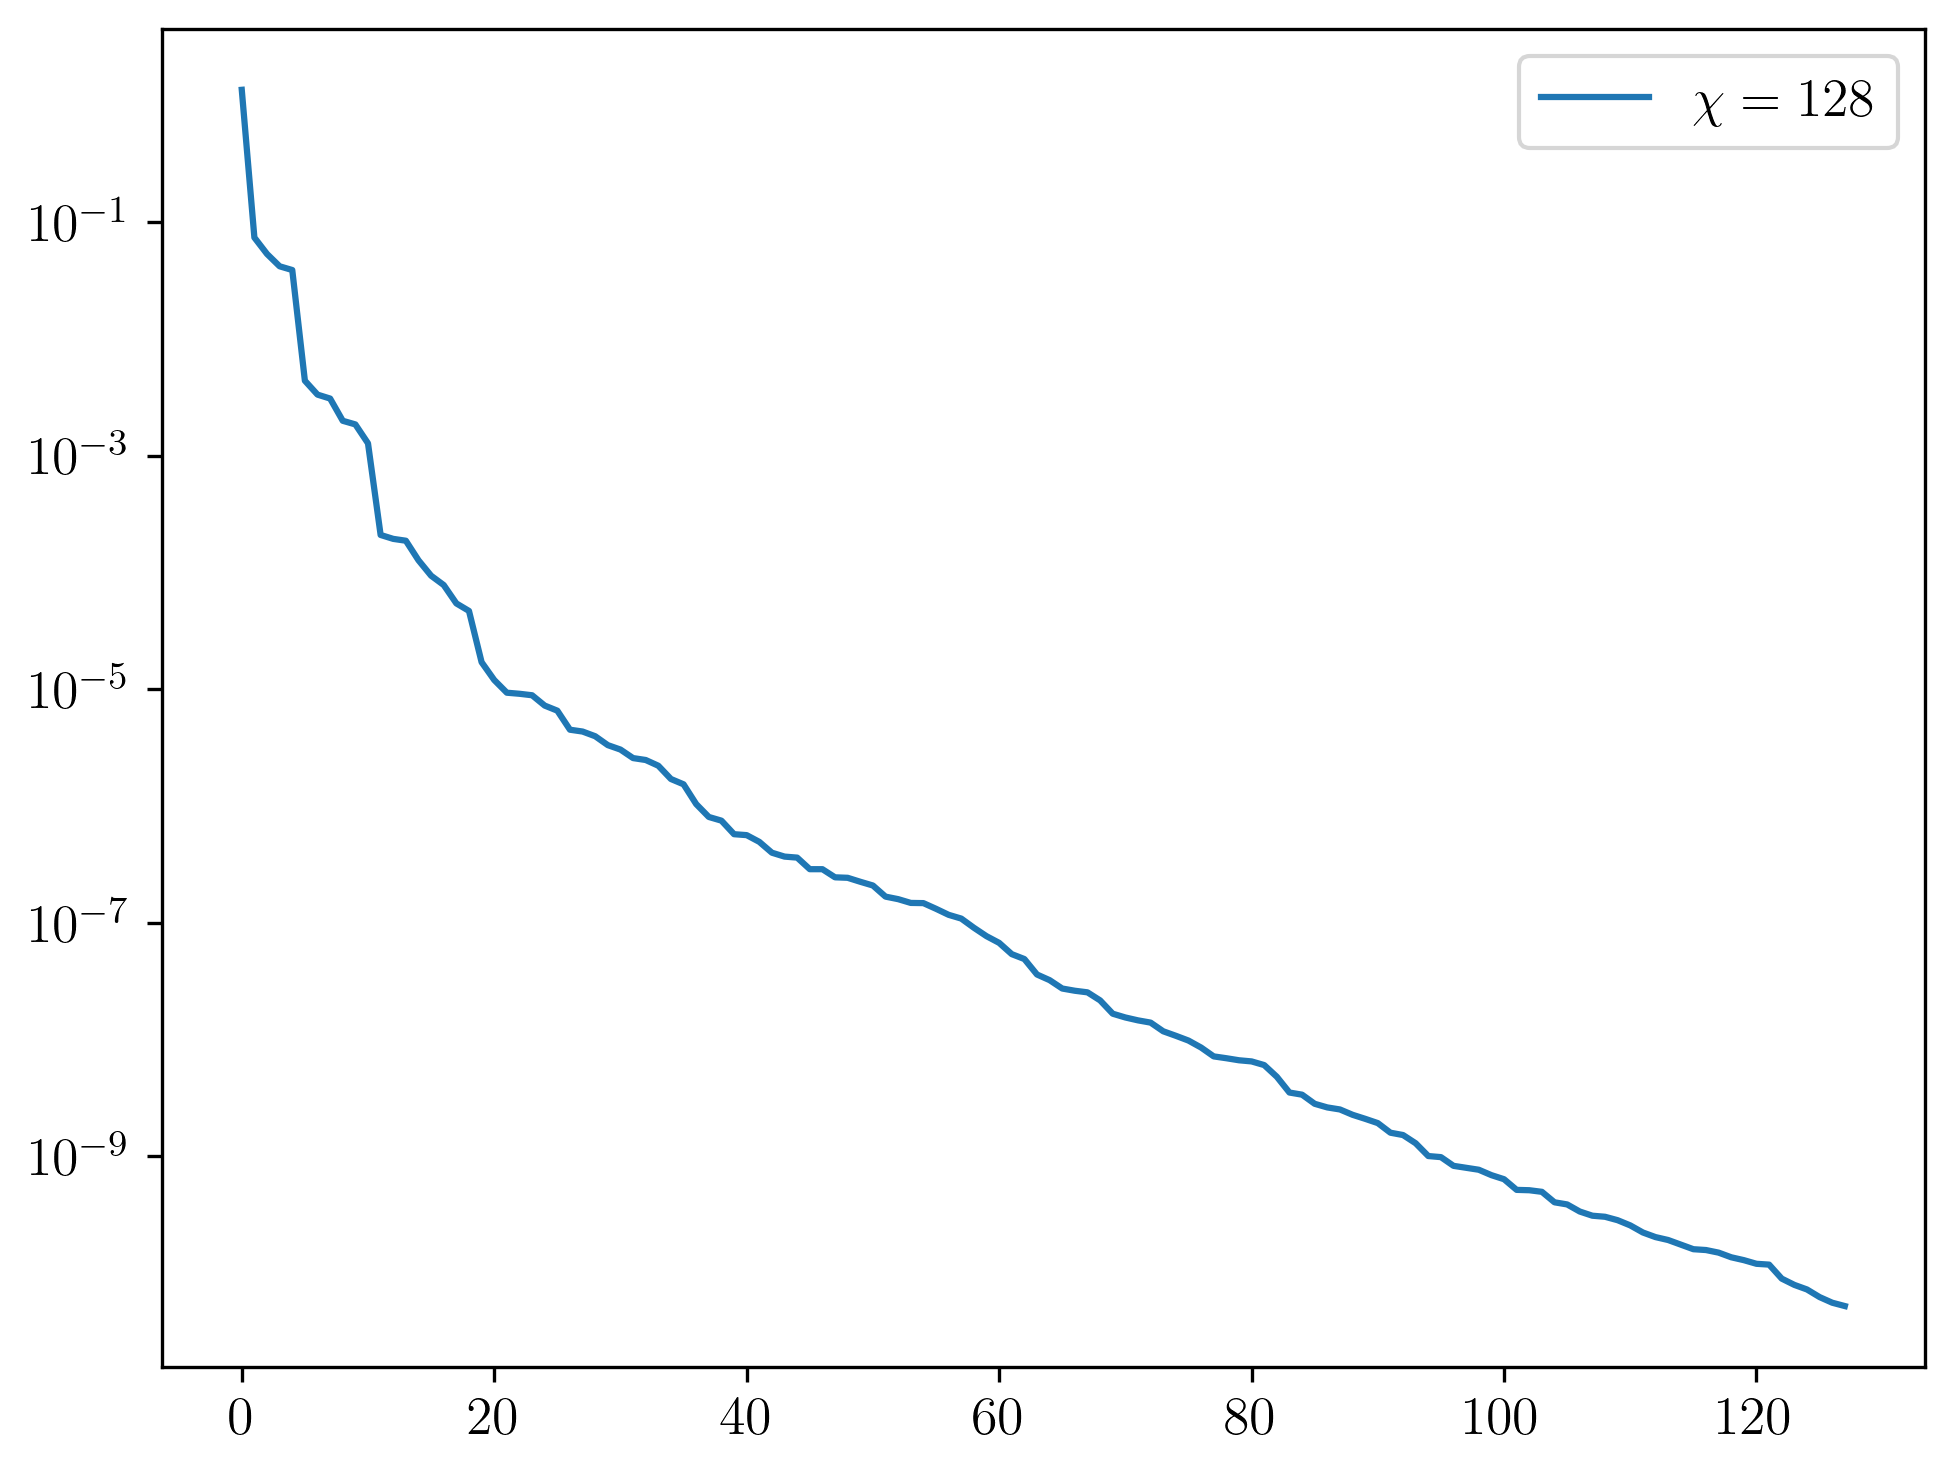

In [237]:
for sm, chi in zip(sm_crit, chis):
    plt.plot(range(len(sm)), sm, '-', label=f"$\chi={chi}$")
plt.legend()
plt.yscale('log')
plt.show()

In [2]:
# let us retrieve the schmidt values from the tensors
Ls = [4,5,6]
chis = [64,128,256]
h = 3.06
schmidt_vals_L = []
for L, chi in zip(Ls, chis):
    lattice = MPS(L=L+1, d=2**L, chi=chi, h=h, model="Z2_dual")
    lattice.load_sites(path="/Users/fradm/Desktop/projects/1_Z2", precision=2)
    lattice.L = lattice.L - 1
    lattice.canonical_form(svd_direction="right")
    schmidt_vals_L.append(lattice.bonds[lattice.L // 2])

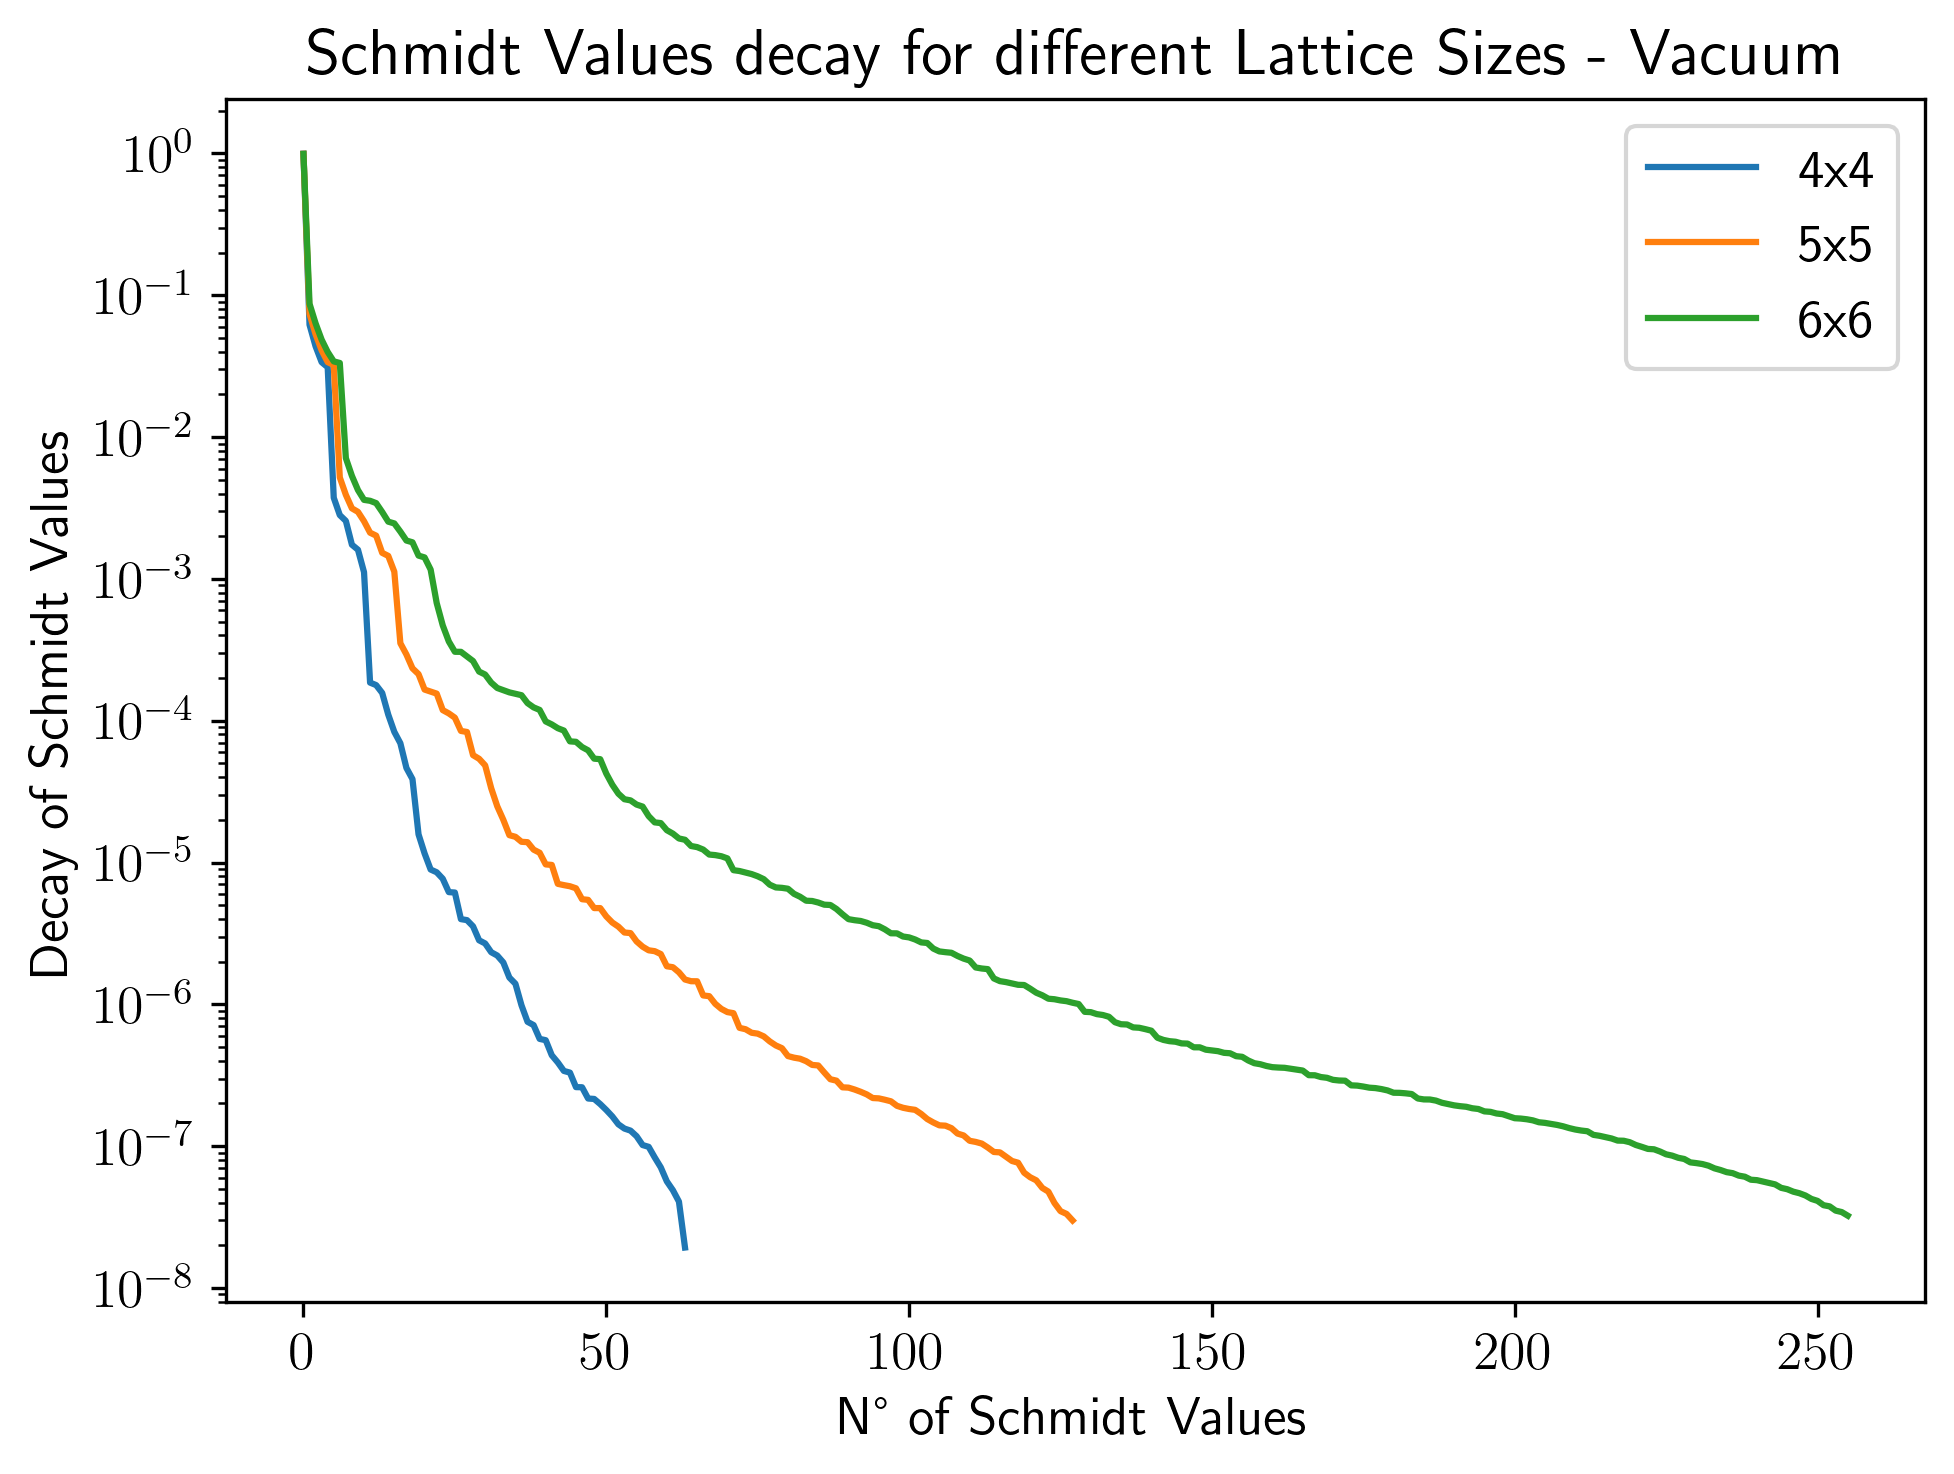

In [3]:
plt.title("Schmidt Values decay for different Lattice Sizes - Vacuum")
for schmidt_vals, L in zip(schmidt_vals_L, Ls):
    plt.plot(schmidt_vals, label=f"{L}x{L}")
plt.yscale('log')
plt.xlabel("N° of Schmidt Values")
plt.ylabel("Decay of Schmidt Values")
plt.legend()
plt.savefig(f"/Users/fradm/Google Drive/My Drive/projects/1_Z2/figures/entropy/schmidt_values_Z2_dual_vacuum.png")
plt.show()

In [8]:
np.save(f"/Users/fradm98/Library/CloudStorage/GoogleDrive-fra.di.marcantonio@gmail.com/My Drive/projects/1_Z2/results/entropy_data/schmidt_values_Z2_dual_direct_lattice_5x5_vacuum_sector_None-None_h_c_3.1_chi_128.npy", schmidt_vals)